<a href="https://colab.research.google.com/github/jdmarshall95/ML-DL-Labs/blob/main/LAB1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Метод ближайших соседей

Для начала подключим библиотеки, которые нам понадобятся.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

#predict library
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загружаем наши данные

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/bmw_pricing_challenge.csv', sep=',')
price = data['price']
m_key = data['model_key']
data.head()

,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,BMW,118,140411,100,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,2018-01-01
1,BMW,M4,13929,317,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,2018-02-01
2,BMW,320,183297,120,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,2018-02-01
3,BMW,420,128035,135,2014-07-01,diesel,red,convertible,True,True,False,False,True,True,True,True,25100,2018-02-01
4,BMW,425,97097,160,2014-12-01,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400,2018-04-01


Данная выборка представляет из себя данные по прадажам б/у автомобилей BMW. Выборка содержит наименование модели, пробег в милях, мощность двигателя, даты регистрации и продажи, типа топлива, цвет, типа кузова и набор опций (8 штук).

Отобразим статистические данные, например соотнесем мощность двигателя и модель:

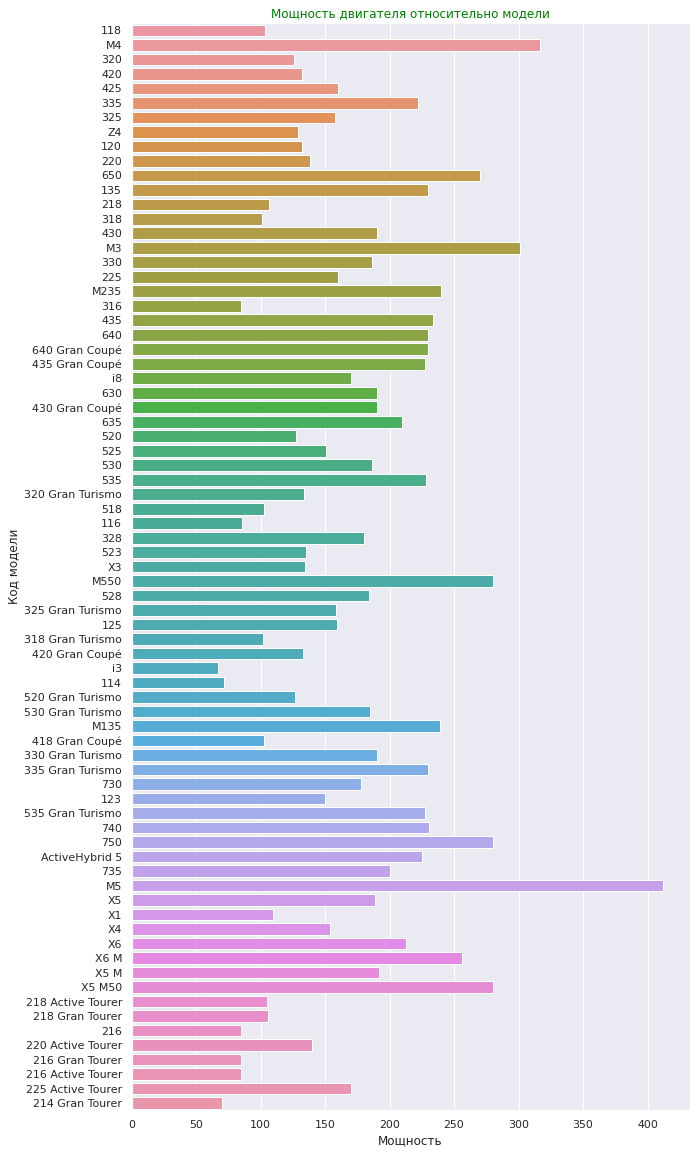

In [ ]:
model_key = data['model_key'].unique()
engine_power = []
for each in model_key:
    x = data[data['model_key']==each]
    engine_power.append(sum(x['engine_power']/len(x)))

plt.figure(figsize=(10,20))
sns.barplot(x=engine_power,y=model_key)
plt.xlabel("Мощность")
plt.ylabel("Код модели")
plt.title("Мощность двигателя относительно модели", color="green")
plt.show()

Посмотрим, автомобили с каким типом топлива статистически преобладают: 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


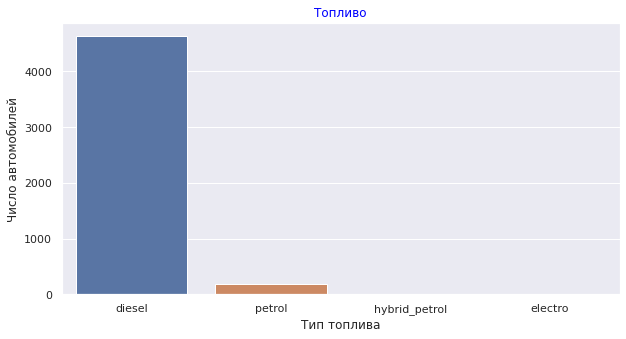

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data['fuel'])
plt.title('Топливо',color="blue")
plt.xlabel("Тип топлива")
plt.ylabel("Число автомобилей")
plt.show()

Аналогично сделаем с типом кузова

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


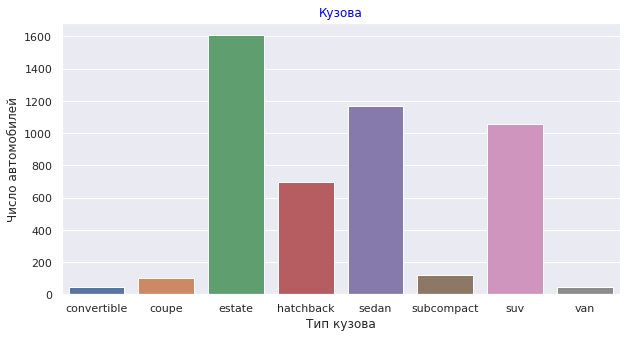

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data['car_type'])
plt.title('Кузова',color="blue")
plt.xlabel("Тип кузова")
plt.ylabel("Число автомобилей")
plt.show()

Как мы видим, преобладают дизельные универсалы, седаны и "джипы", что позволяет сделать вывод, что анализируется европейский рынок.


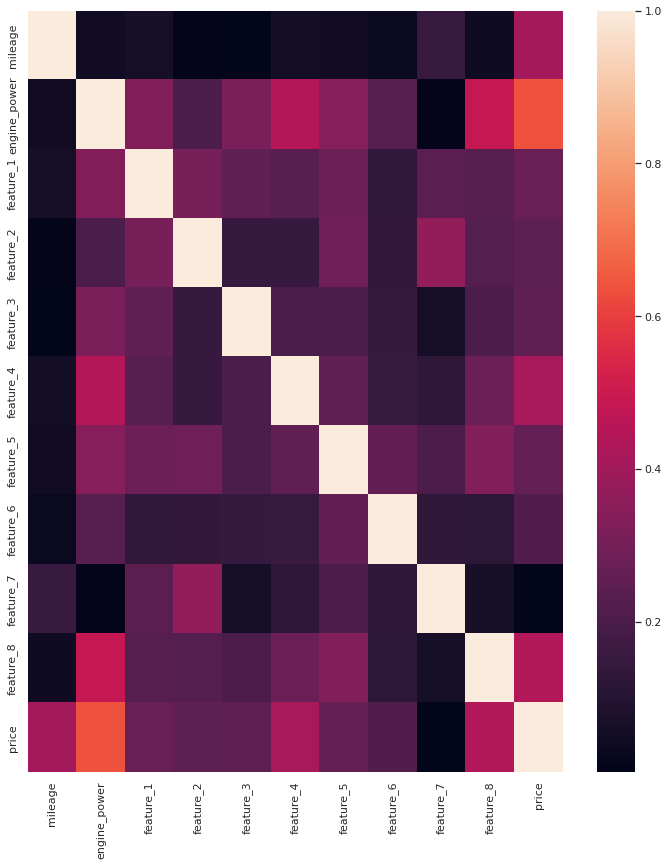

In [ ]:
# Картинку отрисуем с помощью библиотеки seaborn
import seaborn as sns
# Подсчитаем корреляцию и возьмем модуль от нее
corr = data.corr().abs()
sns.set(rc={'figure.figsize':(12, 14)})
# Нарисуем картинку
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Как мы видим, в данной выборке почти отсутствуют высококоррелирующие признаки, удалять переменные нет смысла. Но для упрощения можно убрать информацию о производителе (так как это все BMW) и код модели (его можно было бы заменить на числовое значение, но временно упростим задачу), так как нас интересует "среднее" значение.


In [ ]:
data.drop(['maker_key','model_key'],axis=1,inplace=True)
data.head()

,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,140411,100,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,2018-01-01
1,13929,317,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,2018-02-01
2,183297,120,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,2018-02-01
3,128035,135,2014-07-01,diesel,red,convertible,True,True,False,False,True,True,True,True,25100,2018-02-01
4,97097,160,2014-12-01,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400,2018-04-01


Дата регистрации важна с точки зрения определения возраста автомобиля. Мы должны довести эту информацию до статуса, который она может использовать. Условно разделим их на 3. Я дал каждому интервалу номер, так что я могу использовать его в своей модели. 

In [ ]:
data['RegistrationDate'] = [1 if(i>="1990-03-01" and i<"2000-01-01") else 2 if(i>="2000-01-01" and i<"2010-01-01")
                            else 3 for i in data['registration_date']]

Похожим образом поступим с датой продажи.

In [ ]:
data['SoldAt'] =[1 if(i=="2018-01-01") else 2 if(i=="2018-02-01") else 3 if(i=="2018-03-01")
                 else 4 if(i=="2018-04-01") else 5 if(i=="2018-05-01") else 6 if(i=="2018-06-01")
                 else 7 if(i=="2018-07-01") else 8 if(i=="2018-08-01")
                 else 9 if(i=="2018-09-01") else 0 for i in data['sold_at']]

Покупая автомобиль, мы обращаем внимание на тип топлива. Мы должны преобразовать эту информацию, как и впредыдущем случае, чтобы использовать его в своей модели. 

In [ ]:
data['fuel'] = data['fuel'].replace("diesel",1)
data['fuel'] = data['fuel'].replace("petrol",2)
data['fuel'] = data['fuel'].replace("hybrid_petrol",3)
data['fuel'] = data['fuel'].replace("electro",4)

Аналогично поступим с типом кузова и его цветом.

In [ ]:
data['paint_color'] = data['paint_color'].replace("black",1)
data['paint_color'] = data['paint_color'].replace("grey",2)
data['paint_color'] = data['paint_color'].replace("white",3)
data['paint_color'] = data['paint_color'].replace("red",4)
data['paint_color'] = data['paint_color'].replace("silver",5)
data['paint_color'] = data['paint_color'].replace("blue",6)
data['paint_color'] = data['paint_color'].replace("orange",7)
data['paint_color'] = data['paint_color'].replace("beige",8)
data['paint_color'] = data['paint_color'].replace("brown",9)
data['paint_color'] = data['paint_color'].replace("green",10)
data['car_type'].unique()
data['car_type'] = data['car_type'].replace("convertible",1)
data['car_type'] = data['car_type'].replace("coupe",2)
data['car_type'] = data['car_type'].replace("estate",3)
data['car_type'] = data['car_type'].replace("hatchback",4)
data['car_type'] = data['car_type'].replace("sedan",5)
data['car_type'] = data['car_type'].replace("subcompact",6)
data['car_type'] = data['car_type'].replace("suv",7)
data['car_type'] = data['car_type'].replace("van",8)

Преобразуем значение наличия опции из булева в числовое.

In [ ]:
data['feature_1'] = data['feature_1'].replace(True,1)
data['feature_1'] = data['feature_1'].replace(False,0)
data['feature_2'] = data['feature_2'].replace(True,1)
data['feature_2'] = data['feature_2'].replace(False,0)
data['feature_3'] = data['feature_3'].replace(True,1)
data['feature_3'] = data['feature_3'].replace(False,0)
data['feature_4'] = data['feature_4'].replace(True,1)
data['feature_4'] = data['feature_4'].replace(False,0)
data['feature_5'] = data['feature_5'].replace(True,1)
data['feature_5'] = data['feature_5'].replace(False,0)
data['feature_6'] = data['feature_6'].replace(True,1)
data['feature_6'] = data['feature_6'].replace(False,0)
data['feature_7'] = data['feature_7'].replace(True,1)
data['feature_7'] = data['feature_7'].replace(False,0)
data['feature_8'] = data['feature_8'].replace(True,1)
data['feature_8'] = data['feature_8'].replace(False,0)

Отобразим получившуюся очищеную выборку, предварительно удалив лишние параметры:

In [ ]:
data.drop(['registration_date','sold_at'],axis=1,inplace=True)
data.head()

,mileage,engine_power,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,RegistrationDate,SoldAt
0,140411,100,1,1,1,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,11300,3,1
1,13929,317,2,2,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,69700,3,2
2,183297,120,1,3,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,10200,3,2
3,128035,135,1,4,1,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,25100,3,2
4,97097,160,1,5,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,33400,3,4


# Machine learning

Выделим в нашей выборке целевую переменную, а также разделим ее на тренировочную и тестовую.

In [ ]:
X = data.drop(['feature_1'], axis=1)
y = data['feature_1']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

Проведём классификацию с помощью метода ближайших соседей.

In [ ]:
# импортируем класс классификатора по ближайшим соседям
from sklearn.neighbors import KNeighborsClassifier
print(X_train)
# создадим наш классификатор. Гиперпараметр у этого алгоритма один - количество соседей.
clf = KNeighborsClassifier(n_neighbors=5)
# обучим классификатор на тренировочной выборке
clf.fit(X_train, y_train)
# подсчитаем долю верных ответов алгоритма на тестовой выборке.
# Есть и другие метрики качества - о них будет рассказано на следующей лабе
clf.score(X_test, y_test)

      mileage  engine_power  fuel  ...  price  RegistrationDate  SoldAt
2289   193477           100     1  ...  12900                 3       7
4119   117507           190     1  ...  34500                 3       4
3285   177762           135     1  ...  18400                 3       6
3692   269389            90     1  ...   3300                 2       4
3723   186916           100     1  ...   4000                 2       5
...       ...           ...   ...  ...    ...               ...     ...
2276    42240           100     1  ...  25100                 3       6
1153   229437           100     1  ...   6000                 2       5
4786   122588           190     1  ...  42800                 3       9
3408   365452           120     1  ...   3400                 2       7
1661   169643           155     1  ...  21500                 3       8

[3632 rows x 15 columns]


0.6498761354252683

Рассмотрим влияние гиперпараметра на качество классификации.

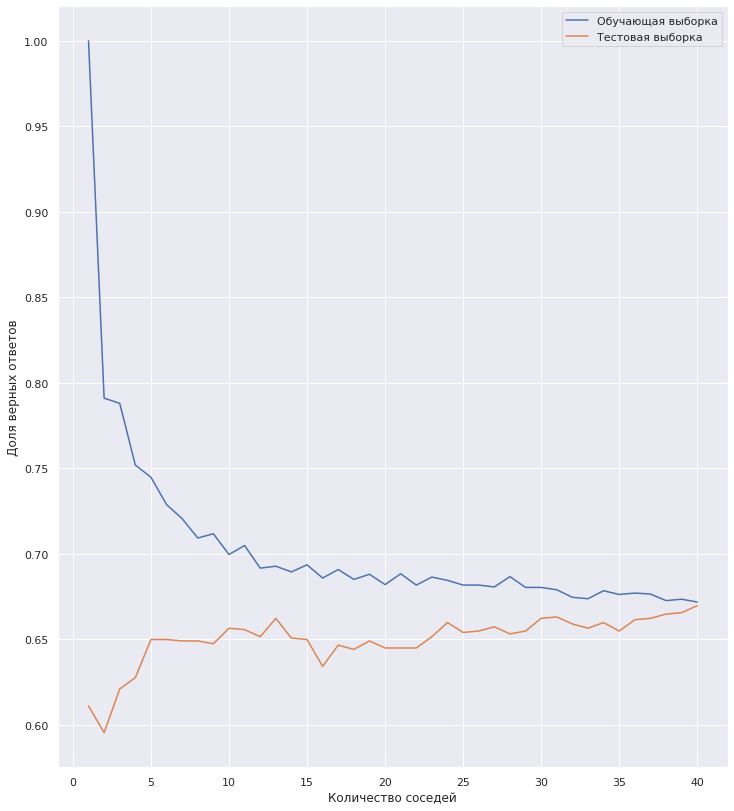

In [ ]:
# Создадим пустой словарь. Будем добавлять в него значения наших "скоров". Ключами будет значение гиперпараметра,
# значениями - качество работы. Рассмотрим отдельно качество на тренировочной выборке и на тестовой.
train_scores = {}
test_scores = {}

# для n в диапазоне от 1 до 40 включительно
for n in range(1, 41):
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(X_train, y_train)
    # значение качества на текущей итерации:
    current_train_score = clf.score(X_train, y_train)
    current_test_score = clf.score(X_test, y_test)
    # запишем его в наши словари
    train_scores[n] = current_train_score
    test_scores[n] = current_test_score

# нарисуем графики
plt.plot(list(train_scores.keys()), list(train_scores.values()), label='Обучающая выборка')
plt.plot(list(test_scores.keys()), list(test_scores.values()), label='Тестовая выборка')
plt.xlabel('Количество соседей')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()